## Step 1: Data Preprocessing

### Raw Data Import

In [1]:
import pandas as pd
import glob
import os

# Path to the directory containing all CSV files relative to the Jupyter notebook location
directory_path = os.path.join("..", "Rawdata")

# List all CSV files in the directory
file_paths = glob.glob(os.path.join(directory_path, "*.csv"))

# Load all CSV files and concatenate them into one DataFrame
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)
    
# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

df = df.sort_values(by=['Date/Time'])

print(df.head())


                Date/Time      Lat      Lon    Base
2147937  4/1/2014 0:00:00  40.7188 -73.9863  B02598
2439200  4/1/2014 0:00:00  40.7215 -73.9952  B02682
2147936  4/1/2014 0:00:00  40.7637 -73.9600  B02598
2331199  4/1/2014 0:01:00  40.7355 -73.9966  B02617
2439201  4/1/2014 0:02:00  40.7184 -73.9601  B02682


### Data Description

In [2]:
# Check for size
print(len(df))

4534327


In [3]:
# Print the type of each column
print(df.dtypes)

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object


In [4]:
import pandas.api.types as ptypes

# Function to determine if a column is numerical or categorical
def classify_columns(df):
    for column in df.columns:
        if ptypes.is_numeric_dtype(df[column]):
            print(f"Column {column} is Numerical")
        elif ptypes.is_string_dtype(df[column]) or ptypes.is_categorical_dtype(df[column]):
            print(f"Column {column} is Categorical")
        else:
            print(f"Column {column} is of type {df[column].dtype}")

# Classify the columns
classify_columns(df)

Column Date/Time is Categorical
Column Lat is Numerical
Column Lon is Numerical
Column Base is Categorical


In [5]:
# Count the total number of bases
total_bases = df['Base'].nunique()

# Display the total number of vehicles
print("Total number of bases:", total_bases)

Total number of bases: 5


### Data Quality Check

In [6]:
# Check for missing values in each column
missing_values = df.isnull().any()

# Display columns with missing values, if any
print("Columns with missing values:")
print(missing_values[missing_values])

Columns with missing values:
Series([], dtype: bool)


In [7]:
# Convert Date/Time column to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')

# Create new columns for 'Date' and 'Time' from 'Date/Time' column
df['Date'] = df['Date/Time'].dt.date
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = df['Date/Time'].dt.time
df['Hour'] = df['Date/Time'].dt.hour 

# Check for missing or invalid dates and times
invalid_dates = df['Date/Time'].isnull()
if invalid_dates.any():
    print("Invalid date/time values:")
    print(df[invalid_dates])

In [8]:
# Check for valid latitude and longitude ranges
invalid_lat = (df['Lat'] < -90) | (df['Lat'] > 90)
invalid_lon = (df['Lon'] < -180) | (df['Lon'] > 180)
if invalid_lat.any() or invalid_lon.any():
    print("\nInvalid latitude or longitude values:")
    print(df[invalid_lat | invalid_lon])

In [9]:
# Check for unexpected Base values
unexpected_base_values = ~df['Base'].isin(['B02512', 'B02598', 'B02617', 'B02682', 'B02764'])
if unexpected_base_values.any():
    print("\nUnexpected Base values:")
    print(data[unexpected_base_values])

### Clustering

In [10]:
from sklearn.cluster import KMeans

X = df[['Lat', 'Lon']]

# Fit K-Means model
kmeans = KMeans(n_clusters=10, random_state=42, n_init = 10) #Set 10 clusters
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Print cluster centers
print(cluster_centers)


[[ 40.78511583 -73.95691565]
 [ 40.65426886 -73.78100409]
 [ 40.66846762 -73.9800213 ]
 [ 40.69879499 -74.20305777]
 [ 40.76412888 -73.86620222]
 [ 40.77775737 -73.50419636]
 [ 40.75610944 -73.98209747]
 [ 40.91973127 -73.8529558 ]
 [ 40.71022137 -73.94605119]
 [ 40.72697703 -73.99997393]]


In [11]:
# Get the cluster assignments for each data point
df['Cluster'] = kmeans.labels_

# Group by cluster and count the number of records in each cluster
cluster_counts = df.groupby('Cluster').size().reset_index(name='Count')

# Create a GeoDataFrame with centroids based on cluster centers
cluster_centroids = pd.DataFrame(cluster_centers, columns=['Lat', 'Lon'])
cluster_centroids['Cluster'] = range(len(cluster_centers))

# Merge cluster count data with cluster centroids
cluster_geo_count_df = pd.merge(cluster_centroids, cluster_counts, on='Cluster')

cluster_geo_count_df.head(10)

,Lat,Lon,Cluster,Count
0,40.785116,-73.956916,0,543221
1,40.654269,-73.781004,1,128843
2,40.668468,-73.980021,2,284925
3,40.698795,-74.203058,3,45122
4,40.764129,-73.866202,4,155989
5,40.777757,-73.504196,5,10437
6,40.756109,-73.982097,6,1510021
7,40.919731,-73.852956,7,31462
8,40.710221,-73.946051,8,303136
9,40.726977,-73.999974,9,1521171


In [12]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Function to retrieve suburb postcode based on latitude and longitude
def get_suburb(lat, lon):
    # Create a geolocator object using Nominatim with a custom user agent
    geolocator = Nominatim(user_agent="uniproject")
    
    # Wrap the geolocator.reverse function with RateLimiter to control the rate of API calls
    reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1, max_retries=0)
    
    # Perform reverse geocoding to get location information based on lat, lon
    location = reverse((lat, lon), exactly_one=True)
    
    if location:
        # Extract address information from the location result
        address = location.raw.get('address', {})
         # Get the postcode from the address dictionary
        postcode = address.get('postcode', None)
        return postcode
    else:
        return None


# Add suburb names to cluster_geo_count_df
cluster_geo_count_df['Postcode'] = cluster_geo_count_df.apply(lambda row: get_suburb(row['Lat'], row['Lon']), axis=1)

cluster_geo_count_df.head(10)

,Lat,Lon,Cluster,Count,Postcode
0,40.785116,-73.956916,0,543221,10128
1,40.654269,-73.781004,1,128843,11430
2,40.668468,-73.980021,2,284925,11215
3,40.698795,-74.203058,3,45122,07112
4,40.764129,-73.866202,4,155989,11369
5,40.777757,-73.504196,5,10437,11801
6,40.756109,-73.982097,6,1510021,10036
7,40.919731,-73.852956,7,31462,10704
8,40.710221,-73.946051,8,303136,11206
9,40.726977,-73.999974,9,1521171,10012


In [13]:
# Merge suburb names back into the main DataFrame based on the cluster labels
df = pd.merge(df, cluster_geo_count_df[['Cluster', 'Postcode']], on='Cluster', how='left')

In [14]:
# Add neighborhood names, source: unitedstateszipcodes.org

neighborhood = {
    '10036':'Clinton',
    '11430':'Queens',
    '11369':'East Elmhurst',
    '11215':'South Slope',
    '11206':'Williamsburg',
    '07112':'Weequahic',
    '10128':'Yorkville',
    '10704':'Dunwoodie',
    '11801':'Oyster Bay',
    '10012':'NoHo'
}

# Create new column for neighborhoods
df['Neighborhood'] = df['Postcode'].map(neighborhood)

### Feature Engineering

In [15]:
import holidays as pyholidays

def add_columns(df):

    # Create a column for the month
    df['Month'] = df['Date'].dt.month

    # Create a column for the weekday
    df['Weekday'] = df['Date'].dt.strftime('%w')
    
    # Create a column for the weekday type
    df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

    # Initialize holidays
    us_holidays = pyholidays.US()

    # Create a column to check if each date is a holiday
    df['Holiday'] = df['Date'].apply(lambda x: x in us_holidays)
    
    # Add a column 'Hour_Category' to the DataFrame indicating weekday or weekend
    df['Hour_Category'] = df.apply(lambda row: categorize_hour(int(row['Hour']), row['IsWeekend'] == 0), axis=1)


In [16]:
# Function to categorize the hours
def categorize_hour(hour, is_weekday):
    if 7 <= hour < 10 and is_weekday:  # Morning rush hours on weekdays
        return 'Morning Rush'
    elif 16 <= hour < 19 and is_weekday:  # Evening rush hours on weekdays
        return 'Evening Rush'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [17]:
# Create a column for the month name
df['Month_Name'] = df['Date'].dt.strftime('%B')

# Create a column for the day number
df['Day_Number'] = df['Date'].dt.day

# Create a column for the weekday name
df['Weekday_Name'] = df['Date'].dt.strftime('%a')

add_columns(df)

### Aggregated Dataframe

In [18]:
# Ensure the DataFrame is sorted by Date, Hour, and Cluster
df_sorted = df.sort_values(by=['Date', 'Hour', 'Cluster'])

# Calculate total pickups per hour and cluster
df_aggregated = df_sorted.groupby(['Date', 'Hour', 'Cluster']).size().reset_index(name='TotalPickups')

In [19]:
# Create a MultiIndex with all combinations of Date, Hour, and Cluster
date_range = pd.date_range(start=df_aggregated['Date'].min(), end=df_aggregated['Date'].max(), freq='D')
hours = range(24)
clusters = df_aggregated['Cluster'].unique()
index = pd.MultiIndex.from_product([date_range, hours, clusters], names=['Date', 'Hour', 'Cluster'])

# Reindex the DataFrame to include all combinations
df_aggregated = df_aggregated.set_index(['Date', 'Hour', 'Cluster']).reindex(index, fill_value=0).reset_index()

# Concatenate the original aggregated DataFrame with the reindexed DataFrame
df_aggregated = pd.concat([df_aggregated, df.groupby(['Date', 'Hour', 'Cluster']).size().reset_index(name='TotalPickups')], ignore_index=True)

# Fill missing values with zeros
df_aggregated['TotalPickups'] = df_aggregated['TotalPickups'].fillna(0)

# Sort the DataFrame by Date, Hour, and Cluster
df_aggregated = df_aggregated.sort_values(by=['Date', 'Hour', 'Cluster']).reset_index(drop=True)

df_aggregated = df_aggregated.drop_duplicates()

print(len(df_aggregated))

43920


In [20]:
add_columns(df_aggregated)

# Combine Date and Hour into a Datetime column
df_aggregated['Datetime'] = df_aggregated['Date'] + pd.to_timedelta(df_aggregated['Hour'], unit='h')

df_aggregated = df_aggregated.drop(['Date'], axis =1)

### Outlier Detection

In [22]:
import numpy as np

# Function to detect outliers using Z-score method
def detect_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    return np.abs(z_scores) > threshold

# Apply the function to each cluster
outliers_df = pd.DataFrame()

for cluster in df_aggregated['Cluster'].unique():
    df_cluster = df_aggregated[df_aggregated['Cluster'] == cluster].copy()  # Create a copy of df_cluster
    outliers = detect_outliers_zscore(df_cluster['TotalPickups'])
    df_cluster.loc[:, 'Outlier'] = outliers
    outliers_df = pd.concat([outliers_df, df_cluster[outliers]])

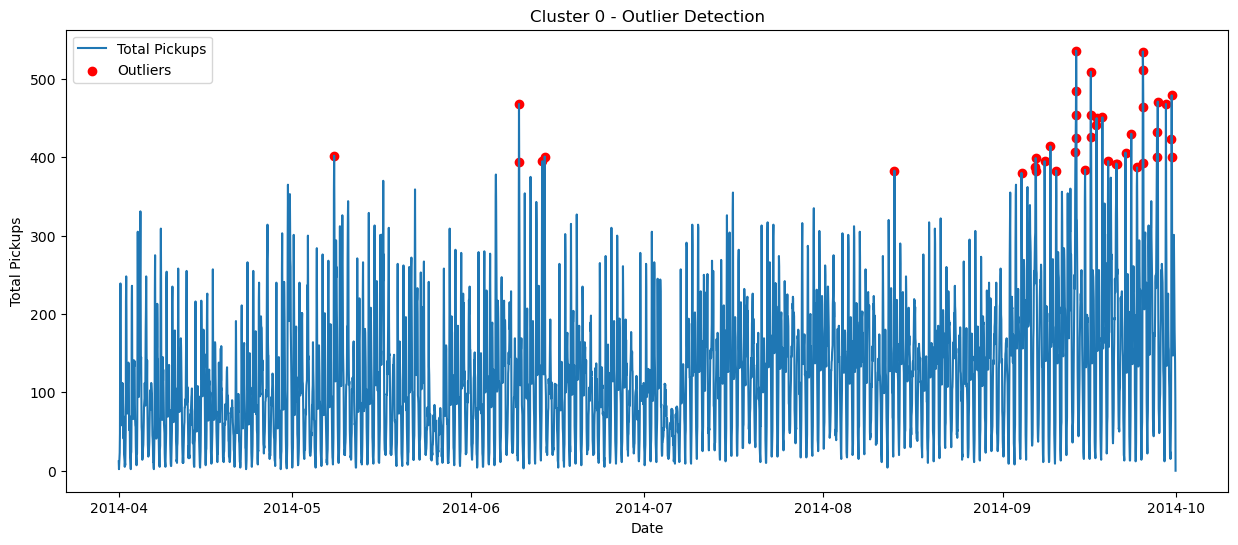

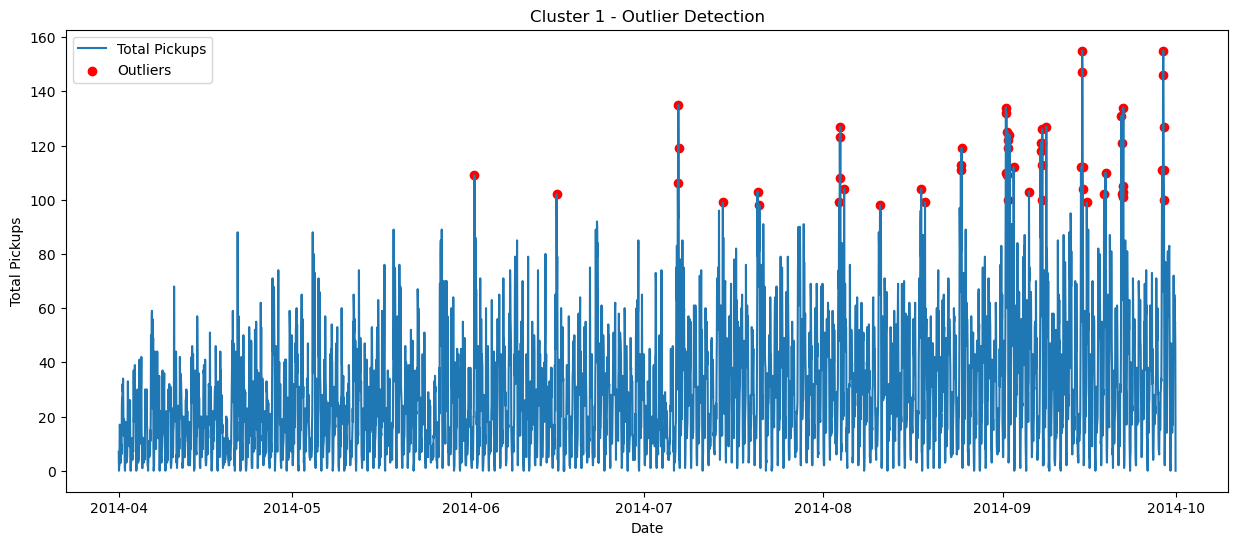

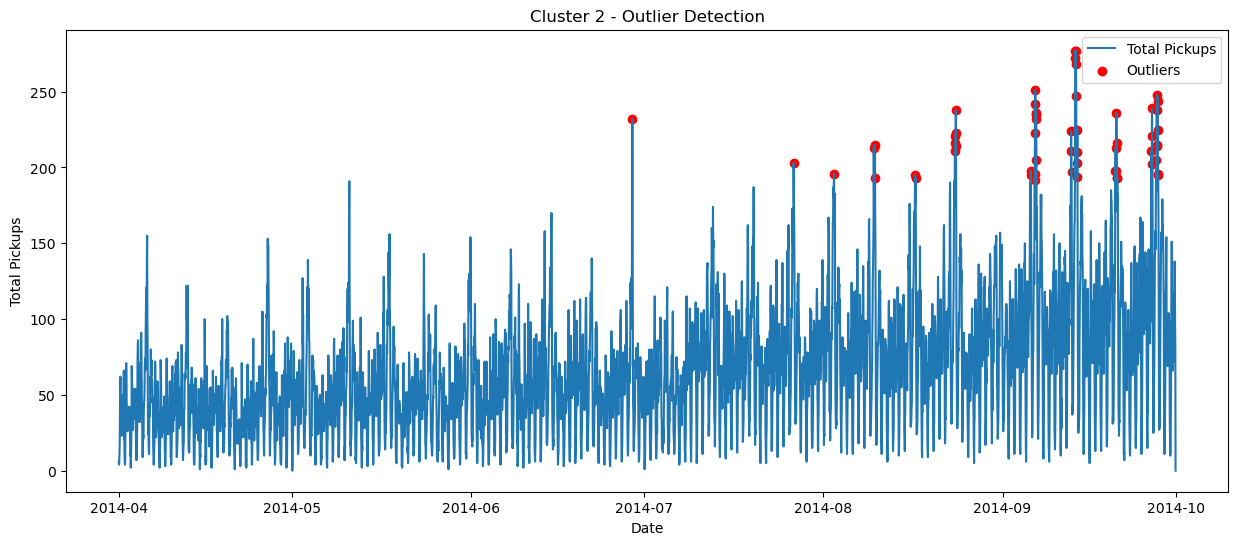

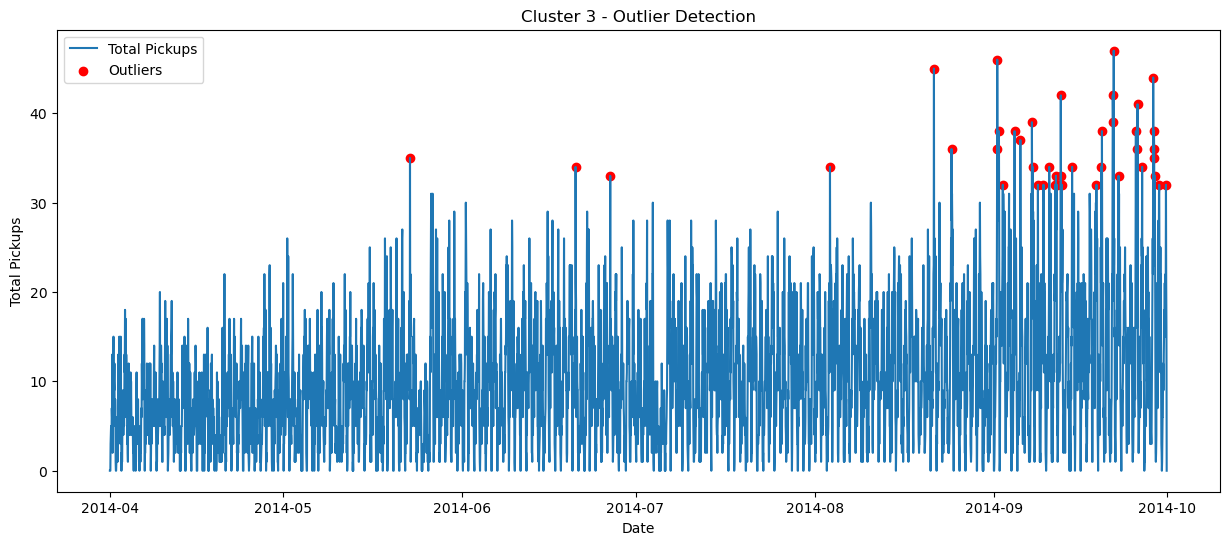

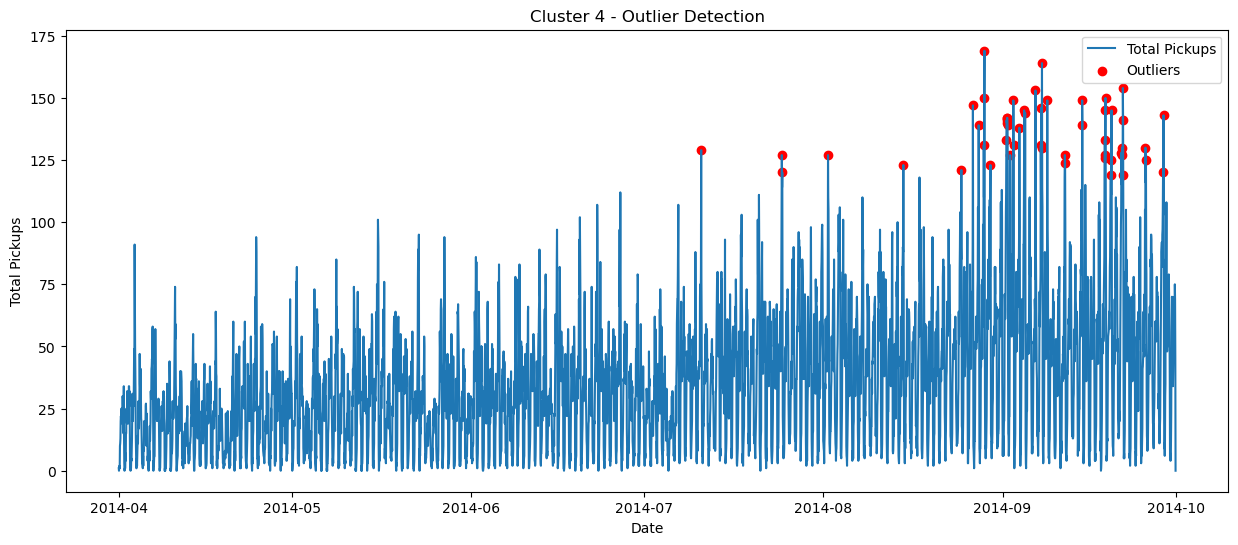

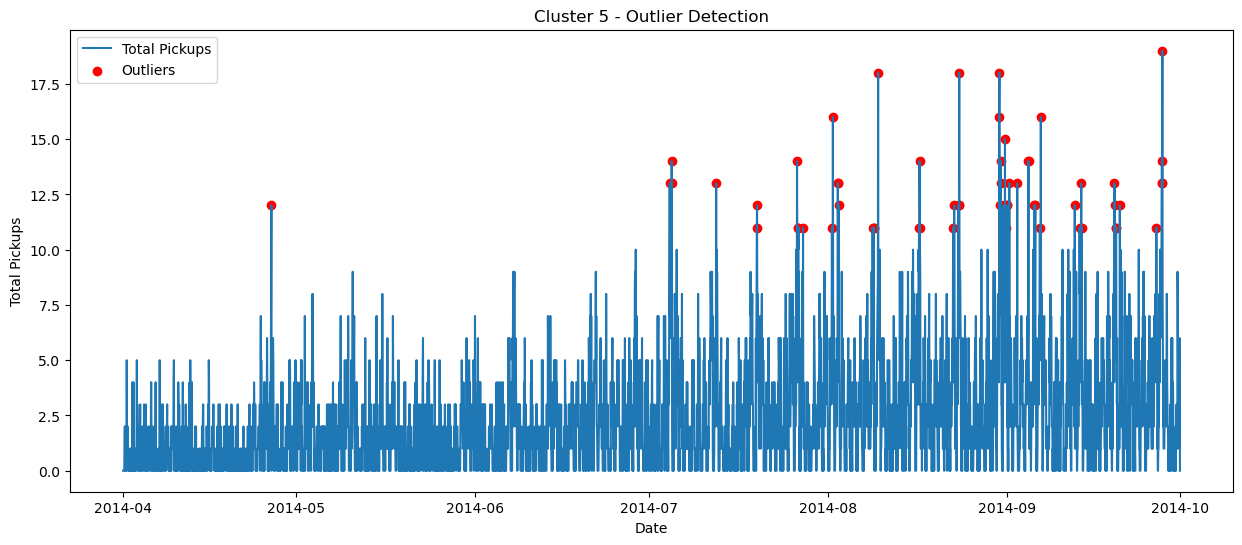

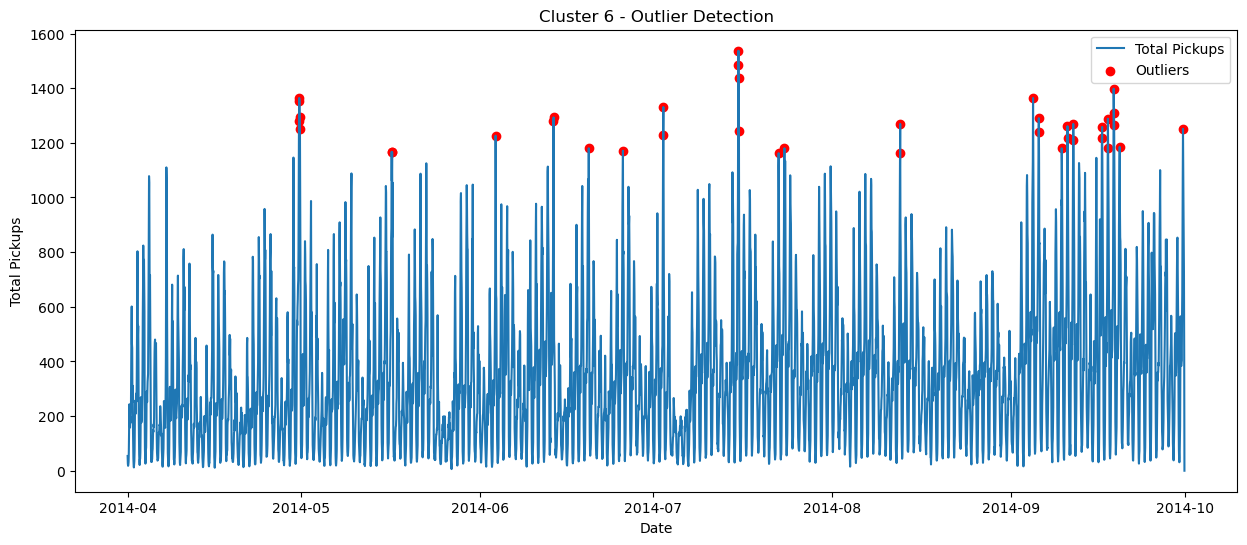

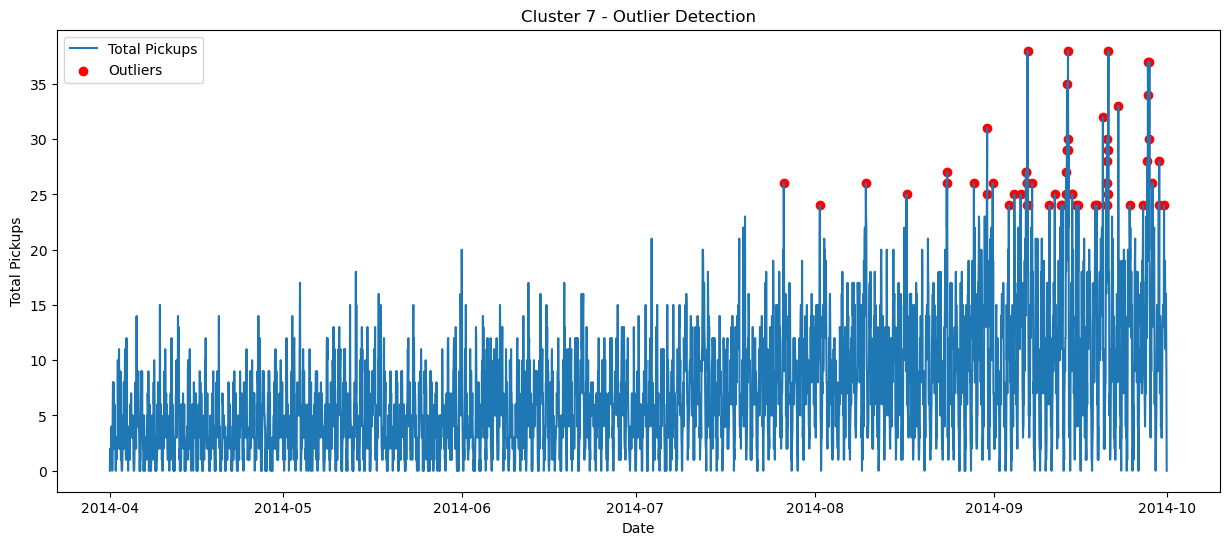

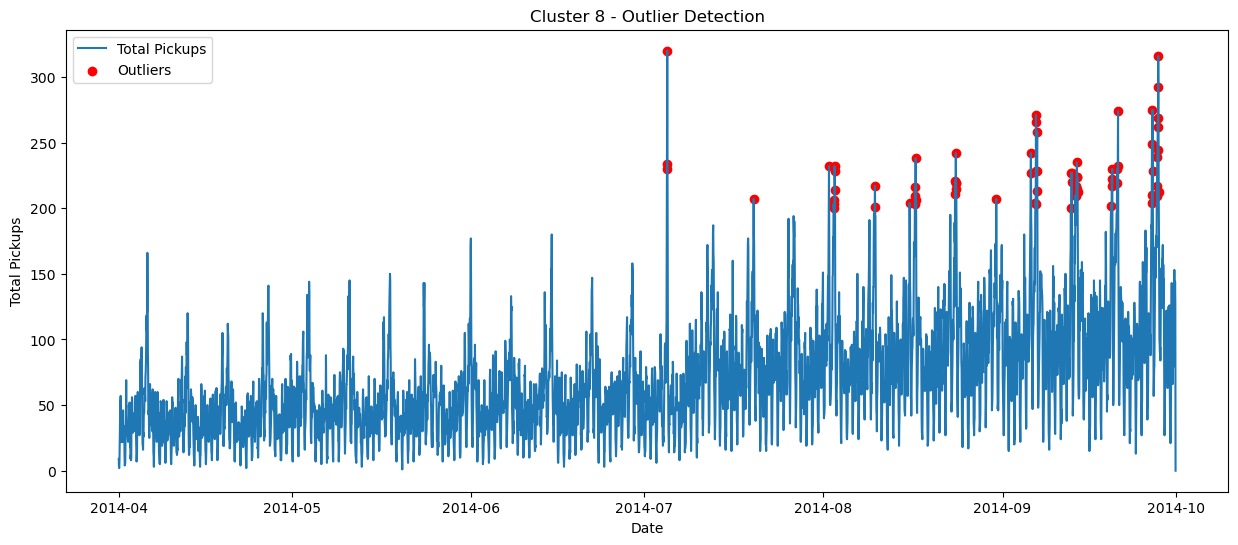

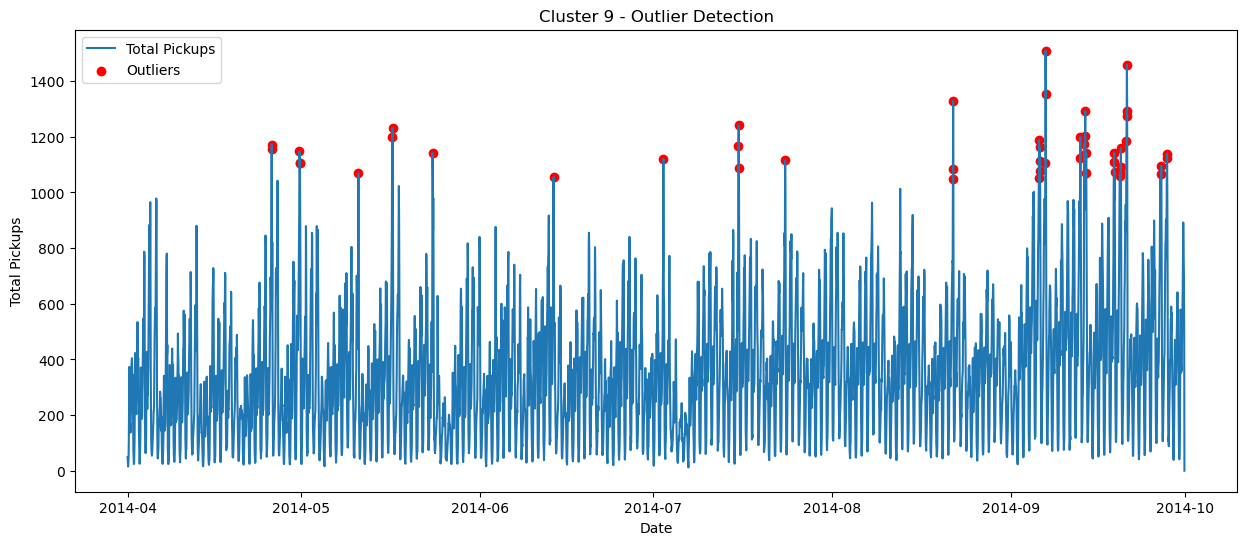

In [25]:
import matplotlib.pyplot as plt

# Visualization of Outliers for each cluster
for cluster in range(10):
    df_cluster = df_aggregated[df_aggregated['Cluster'] == cluster]  # Define df_cluster for each cluster
    outliers_cluster = outliers_df[outliers_df['Cluster'] == cluster]
    
    plt.figure(figsize=(15, 6))
    plt.plot(df_cluster['Datetime'], df_cluster['TotalPickups'], label='Total Pickups')
    plt.scatter(outliers_cluster['Datetime'], outliers_cluster['TotalPickups'], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel('Total Pickups')
    plt.title(f'Cluster {cluster} - Outlier Detection')
    plt.legend()
    plt.show()

In [26]:
# Replace outliers with the mean for each cluster and save outliers
for cluster in df['Cluster'].unique():
    df_cluster = df_aggregated[df_aggregated['Cluster'] == cluster].copy()  # Create a copy of df_cluster
    outliers = detect_outliers_zscore(df_cluster['TotalPickups'])
    
    # Store outliers
    df_cluster.loc[outliers, 'Outlier'] = outliers
    outliers_df = pd.concat([outliers_df, df_cluster[outliers]])
    
    # Calculate the mean of the nn-outlier data
    mean_value = df_cluster.loc[~outliers, 'TotalPickups'].mean()
    
    # Replace outliers with the mean value
    df_cluster.loc[outliers, 'TotalPickups'] = mean_value
    
    # Update the original dataframe
    df_aggregated.update(df_cluster)

In [27]:
print(df)

                  Date/Time      Lat      Lon    Base       Date      Time  \
0       2014-04-01 00:00:00  40.7188 -73.9863  B02598 2014-04-01  00:00:00   
1       2014-04-01 00:00:00  40.7215 -73.9952  B02682 2014-04-01  00:00:00   
2       2014-04-01 00:00:00  40.7637 -73.9600  B02598 2014-04-01  00:00:00   
3       2014-04-01 00:01:00  40.7355 -73.9966  B02617 2014-04-01  00:01:00   
4       2014-04-01 00:02:00  40.7184 -73.9601  B02682 2014-04-01  00:02:00   
...                     ...      ...      ...     ...        ...       ...   
4534322 2014-09-09 09:59:00  40.7294 -73.9877  B02682 2014-09-09  09:59:00   
4534323 2014-09-09 09:59:00  40.7199 -73.9952  B02682 2014-09-09  09:59:00   
4534324 2014-09-09 09:59:00  40.7182 -74.0016  B02682 2014-09-09  09:59:00   
4534325 2014-09-09 09:59:00  40.7450 -74.0085  B02598 2014-09-09  09:59:00   
4534326 2014-09-09 09:59:00  40.7607 -73.9715  B02617 2014-09-09  09:59:00   

         Hour  Cluster Postcode  Neighborhood Month_Name  Day_N

In [28]:
print(df_aggregated)

       Hour  Cluster  TotalPickups  Month Weekday  IsWeekend Holiday  \
0         0        0          12.0      4       2          0   False   
2         0        1           7.0      4       2          0   False   
4         0        2           6.0      4       2          0   False   
6         0        3           0.0      4       2          0   False   
7         0        4           1.0      4       2          0   False   
...     ...      ...           ...    ...     ...        ...     ...   
86166    23        5           0.0      9       2          0   False   
86167    23        6           0.0      9       2          0   False   
86168    23        7           0.0      9       2          0   False   
86169    23        8           0.0      9       2          0   False   
86170    23        9           0.0      9       2          0   False   

      Hour_Category            Datetime  
0             Night 2014-04-01 00:00:00  
2             Night 2014-04-01 00:00:00  
4        

In [29]:
#dataframe for eda
%store df

#dataframe for time series regression
%store df_aggregated 

Stored 'df' (DataFrame)
Stored 'df_aggregated' (DataFrame)
